In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))  

In [2]:

import os
import random
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# plt.style.use("ggplot")
# %matplotlib inline

from tqdm import tqdm, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [3]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [4]:
train_dir = "C:\\Users\\mglas\\AI Projects\\Segmentation\\dsb-2018\\stage1_train\\"
save_dir =  "C:\\Users\\mglas\\AI Projects\\Segmentation\\dsb-2018\\Saved Models\\"

In [5]:
ids = next(os.walk(train_dir))[1] # list of names all directories in the train path
print("No. of images = ", len(ids))

No. of images =  670


In [6]:
print(ids[0])

00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552


Image data type = uint8
Mask data type = uint8


Text(0.5, 1.0, 'Mask (multiple per image)')

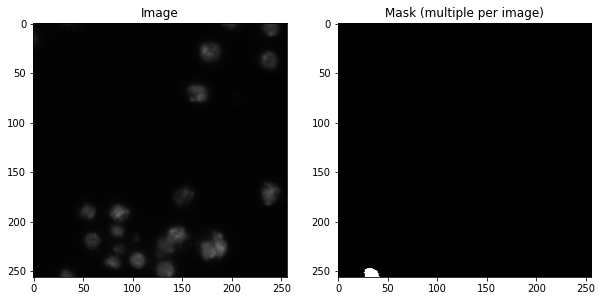

In [7]:
# Get data type of inputs

image = Image.open(train_dir + ids[0] + "\\images\\" + ids[0] + ".png")
im = np.asarray(image)
print("Image data type =", im.dtype)

mask = Image.open(train_dir + ids[0] + "\\masks\\" + "0e548d0af63ab451616f082eb56bde13eb71f73dfda92a03fbe88ad42ebb4881.png")
msk = np.asarray(mask)
print("Mask data type =", msk.dtype)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(image)

ax1.set_title('Image')

ax2.imshow(mask, cmap = 'gray', interpolation = 'bilinear')

ax2.set_title('Mask (multiple per image)')

In [8]:
# Keras converts uint8 to float32 with keras.preprocessing.image.img_to_array()

X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.bool)

In [9]:
load_data = True

In [10]:
# tqdm is used to display the progress bar


if load_data:
    
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):


        image_dir = train_dir + id_ + "\\images\\"

        # Load images
        img = load_img(image_dir + id_ + ".png", color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, (im_width, im_height, 1), mode = 'constant', preserve_range = True)

        # Load masks 
        # multiple masks per image file (each mask = one nucleus)
        
        mask_dir = train_dir + id_ + "\\masks\\"

        mask = np.zeros((im_width, im_height, 1), dtype=np.bool)
        for mask_file in next(os.walk(mask_dir))[2]:
            mask_ = imread(mask_dir + mask_file)
            mask_ = np.expand_dims(resize(mask_, (im_width, im_height), mode='constant', preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)

        # Save images
        X[n] = x_img/255.0
        y[n] = mask/255.0

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [02:53<00:00,  3.87it/s]


In [11]:
if load_data:
    np.save(save_dir + "X_nuclei", X)
    np.save(save_dir + "y_masks", y)
    
else:
    X = np.load(save_dir + "X_nuclei.npy")
    y = np.load(save_dir + "y_masks.npy")   

In [12]:
print("X shape =", X.shape)
print("y shape =", y.shape)

X shape = (670, 128, 128, 1)
y shape = (670, 128, 128, 1)


In [13]:
# Split train, valid, and test

n=len(X)

X_train = X[0:int(0.7*n),:,:,:]
X_valid = X[int(0.7*n):int(0.9*n),:,:,:]
X_test = X[int(0.9*n):n,:,:,:]

y_train = y[0:int(0.7*n),:,:,:]
y_valid = y[int(0.7*n):int(0.9*n),:,:,:]
y_test = y[int(0.9*n):n,:,:,:]

print("X_train.shape =" , X_train.shape)
print("X_valid.shape =", X_valid.shape)
print("X_test.shape =", X_test.shape, "\n")
print("Image data type=", X_train[0].dtype, "\n")

print("y_train.shape =" , y_train.shape)
print("y_valid.shape =", y_valid.shape)
print("y_test.shape =", y_test.shape, "\n")
print("Mask data type =", y[0].dtype, "\n")

# Sanity Check
print("Total Images = ", len(X_train) + len(X_valid) + len(X_test))
print("Total Masks = ", len(y_train) + len(y_valid) + len(y_test))

X_train.shape = (468, 128, 128, 1)
X_valid.shape = (135, 128, 128, 1)
X_test.shape = (67, 128, 128, 1) 

Image data type= float32 

y_train.shape = (468, 128, 128, 1)
y_valid.shape = (135, 128, 128, 1)
y_test.shape = (67, 128, 128, 1) 

Mask data type = bool 

Total Images =  670
Total Masks =  670


Text(0.5, 1.0, 'Mask')

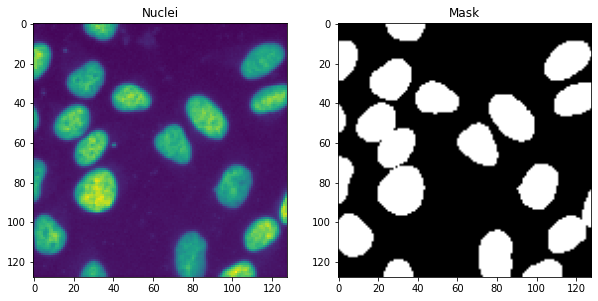

In [14]:
# Visualize any random image along with the mask

ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(X_train[ix, ..., 0])

#     if has_mask:
#         draw a boundary(contour) in the original image separating cell and non-cell areas
#         ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])

ax1.set_title('Nuclei')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')

In [15]:

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [16]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [17]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(lr=5e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [18]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(save_dir + 'model-dbs-2018.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [19]:
results = model.fit(X_train, y_train, batch_size=20, epochs=40, callbacks=callbacks,validation_data=(X_valid, y_valid))

Train on 468 samples, validate on 135 samples
Epoch 1/40
468/468 [==============================] - 5s 10ms/step - loss: 0.6956 - accuracy: 0.6351 - val_loss: 0.7465 - val_accuracy: 0.2165

Epoch 00001: val_loss improved from inf to 0.74651, saving model to C:\Users\mglas\AI Projects\Segmentation\dsb-2018\Saved Models\model-dbs-2018.h5
Epoch 2/40
468/468 [==============================] - 1s 2ms/step - loss: 0.4915 - accuracy: 0.8609 - val_loss: 0.6807 - val_accuracy: 0.5819

Epoch 00002: val_loss improved from 0.74651 to 0.68075, saving model to C:\Users\mglas\AI Projects\Segmentation\dsb-2018\Saved Models\model-dbs-2018.h5
Epoch 3/40
468/468 [==============================] - 1s 2ms/step - loss: 0.3961 - accuracy: 0.9076 - val_loss: 0.6050 - val_accuracy: 0.8590

Epoch 00003: val_loss improved from 0.68075 to 0.60497, saving model to C:\Users\mglas\AI Projects\Segmentation\dsb-2018\Saved Models\model-dbs-2018.h5
Epoch 4/40
468/468 [==============================] - 1s 2ms/step - loss

Epoch 30/40
468/468 [==============================] - 1s 2ms/step - loss: 0.1321 - accuracy: 0.9587 - val_loss: 0.1014 - val_accuracy: 0.9680

Epoch 00030: val_loss improved from 0.10664 to 0.10140, saving model to C:\Users\mglas\AI Projects\Segmentation\dsb-2018\Saved Models\model-dbs-2018.h5
Epoch 31/40
468/468 [==============================] - 1s 2ms/step - loss: 0.1238 - accuracy: 0.9616 - val_loss: 0.1073 - val_accuracy: 0.9633

Epoch 00031: val_loss did not improve from 0.10140
Epoch 32/40
468/468 [==============================] - 1s 2ms/step - loss: 0.1223 - accuracy: 0.9616 - val_loss: 0.0960 - val_accuracy: 0.9712

Epoch 00032: val_loss improved from 0.10140 to 0.09602, saving model to C:\Users\mglas\AI Projects\Segmentation\dsb-2018\Saved Models\model-dbs-2018.h5
Epoch 33/40
468/468 [==============================] - 1s 2ms/step - loss: 0.1153 - accuracy: 0.9633 - val_loss: 0.1013 - val_accuracy: 0.9665

Epoch 00033: val_loss did not improve from 0.09602
Epoch 34/40
468/46

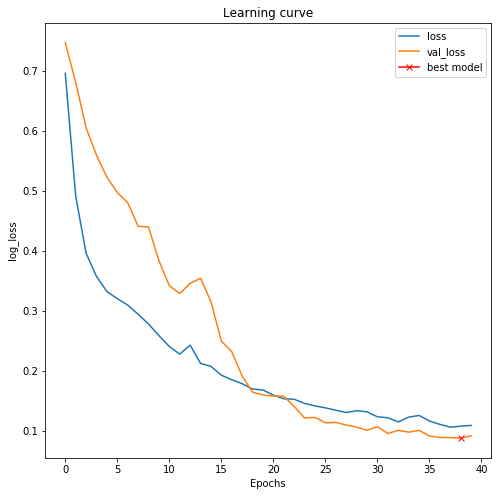

In [20]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [21]:
# load the best model
model.load_weights(save_dir + 'model-dbs-2018.h5')

In [22]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

135/135 [==============================] - 1s 4ms/step


[0.08846428477101856, 0.9706321358680725]

In [23]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_test = model.predict(X_test, verbose=1)

67/67 [==============================] - 0s 3ms/step


In [24]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [29]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    
    ### Plot the results ###
    
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0])
    ax[0].set_title('Cells') 
#     if has_mask:
#         ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])

    ax[1].imshow(y[ix].squeeze(),cmap = 'gray', interpolation = 'bilinear')
    ax[1].set_title('Original Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Cells Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
#     if has_mask:
#         ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Cells Predicted > Thresh');
    

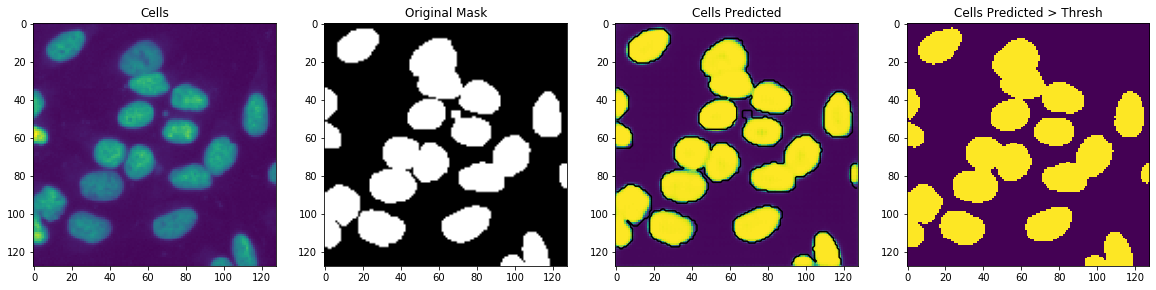

In [31]:
# Check if training data looks all right

ix = None
plot_sample(X_train, y_train, preds_train, preds_train_t, ix = random.randint(0, len(X_train)-1))

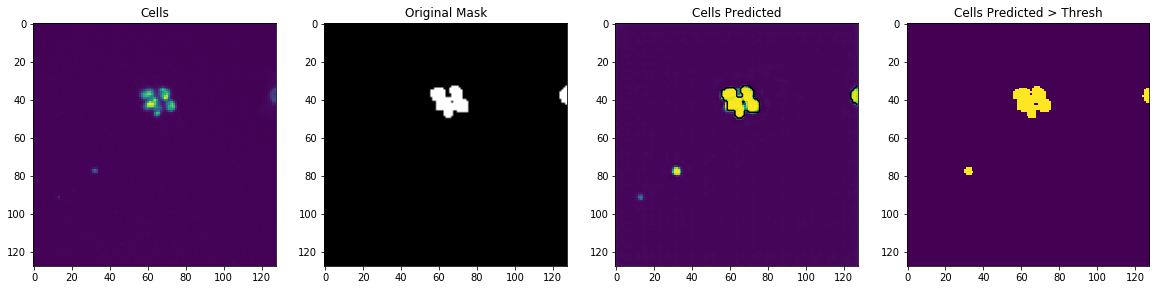

In [32]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix = random.randint(0, len(X_valid)-1))

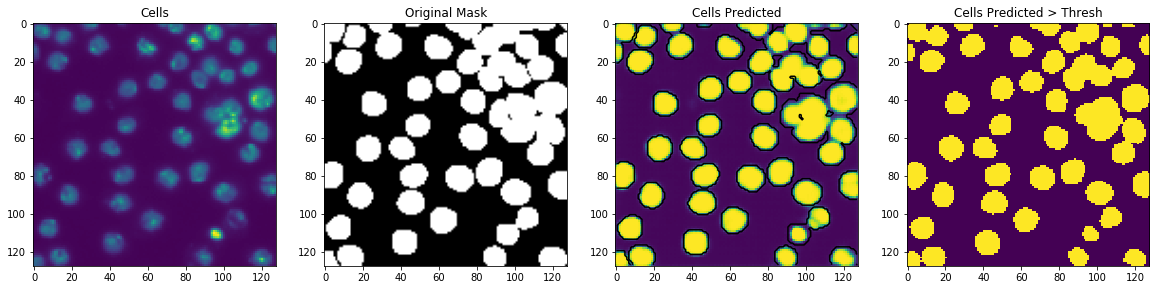

In [34]:
# See how well algorithm does on the test data

plot_sample(X_test, y_test, preds_test, preds_test_t, ix = random.randint(0, len(X_test)-1))

This algorithm finds all nuclei in the image. However can be extended to find only nuclei